<center><img src="img/aism_logo.png" alt="Logo AI Saturdays Madrid" title="Logo AI Saturdays Madrid" width="150"/></center>

# Week 6 Challenge - Movie Reviews Classifier

Un problema que se repite con frecuencia con los datos en forma de texto es el análisis de opiniones/sentimientos el cual, si contamos con un dataset anotado, no deja de ser un problema de clasificación supervisado.

En este _challenge_ crearemos un clasificador de texto genérico que clasifica los textos de reseñas de películas de IMDB en castellano en una de dos categorías: `negativo` o `positivo`. Para ello vamos a aplicar el teorema de Bayes haciendo uso de la implementación del algoritmo Naïve Bayes.

Para crear el dataset que vamos a usar, hemos tomado como base el que podemos encontrar en [Kaggle - IMDB Dataset of 50K Movie Reviews (Spanish)](https://www.kaggle.com/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish), quedándonos solo con las columnas en castellano y limpiando algunas reseñas en inglés que se habían colado.

## Importar librerías

A continuación, te dejamos indicadas las librerías que creemos que vas a necesitar importar para completar el _challenge_, pero puedes importar las que creas necesarias.

In [ ]:
!pip install unidecode

In [2]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#import spacy
from nltk.corpus import stopwords
from unidecode import unidecode
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

## Cargar los datos

**Crear un DataFrame llamado `data` a partir del CSV que contiene los datos con las reseñas de las películas y muestra las 5 primeras filas.**

In [4]:
import csv
data=pd.read_csv('data/IMDB_es.csv', encoding="utf_8")

In [5]:
data

,review_es,sentiment
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...
48177,Pensé que esta película hizo un buen trabajo a...,positivo
48178,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
48179,Soy católica enseñada en escuelas primarias pa...,negativo
48180,Voy a tener que estar en desacuerdo con el com...,negativo


## Análisis de los datos

**Muestras la información abreviada del conjunto de datos.**

In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_es  48182 non-null  object
 1   sentiment  48182 non-null  object
dtypes: object(2)
memory usage: 753.0+ KB


**Aparentemente no hay valores nulos, pero conviene comprobar si tenemos reseñas que son simplemente cadenas vacías ya que no nos sirven y deberíamos eliminarlas. Comprueba si hay reseñas con una longitud de menos de 10 caracteres.**

In [8]:
index=[]
for i in range(0,len(data)):
  if len(data['review_es'][i])<10:
    index.append(i)
print(f'Hay {len(index)} cadenas vacias')

Hay 2 cadenas vacias


In [9]:
data.drop(index,inplace=True)


En este caso no tenemos cadenas vacías, pero como vemos aparecen reseñas que no son tales sino que parecen errores al haber sido guardadas. 

In [10]:
# Resetea el índice
data.reset_index(drop=True, inplace=True)

**Muestra usando un diagrama de barras la distribución de las clases objetivo dentro de la variable `sentiment` e imprime un conteo de las mismas. ¿Qué te indica esto?**

In [11]:
sns.set(font_scale=2)

In [12]:
keys, counts = np.unique(data['sentiment'], return_counts=True)

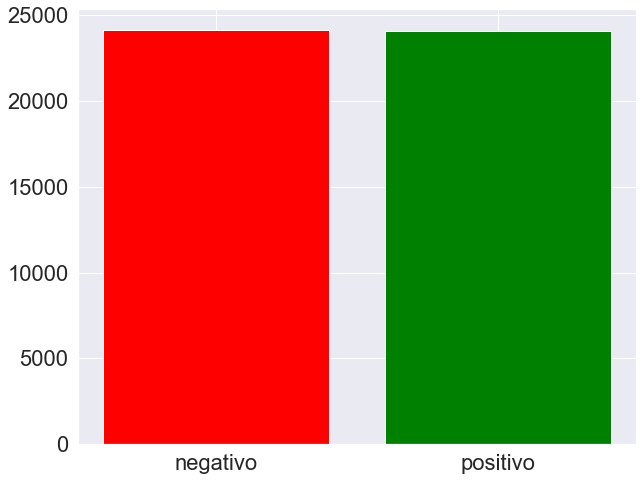

------------
negativo 24131
------------
positivo 24049


In [13]:
# Muestra el gráfico

plt.figure(figsize=(10,8))
plt.bar(keys, counts,color=['red', 'green'])
plt.show()

# Imprime el conteo

print('------------')
print(keys[0],counts[0])
print('------------')
print(keys[1],counts[1])

Estamos trabajando con un conjunto de datos bastante balanceado.

## Preprocesamiento de los textos

**Crea una nueva columna llamada `review_es_clean` que contenga el texto de las reseñas en minúsculas. A partir de ahora, todas las transformaciones que vamos a realizar en los textos se harán sobre esta columna que contendrá el texto de las reseñas preprocesado.**

In [14]:
data['review_es_clean']=data['review_es'].str.lower()

In [15]:
textos= data['review_es_clean']

**Sustituye los signos de puntuación de los textos de las reseñas por un espacio.**

In [16]:
punctuation = '[^\w\s]'

In [17]:
data['review_es_clean']=data['review_es_clean'].str.replace(punctuation,' ',regex=True).str.strip()

In [18]:
data

,review_es,sentiment,review_es_clean
0,Uno de los otros críticos ha mencionado que de...,positivo,uno de los otros críticos ha mencionado que de...
1,Una pequeña pequeña producción.La técnica de f...,positivo,una pequeña pequeña producción la técnica de f...
2,Pensé que esta era una manera maravillosa de p...,positivo,pensé que esta era una manera maravillosa de p...
3,"Básicamente, hay una familia donde un niño peq...",negativo,básicamente hay una familia donde un niño peq...
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,el amor en el tiempo de petter mattei es una...
...,...,...,...
48175,Pensé que esta película hizo un buen trabajo a...,positivo,pensé que esta película hizo un buen trabajo a...
48176,"Mala parcela, mal diálogo, mala actuación, dir...",negativo,mala parcela mal diálogo mala actuación dir...
48177,Soy católica enseñada en escuelas primarias pa...,negativo,soy católica enseñada en escuelas primarias pa...
48178,Voy a tener que estar en desacuerdo con el com...,negativo,voy a tener que estar en desacuerdo con el com...


**Elimina los números de los textos sustituyéndolos por un espacio.**

In [19]:
digits='[0-9]+'

data['review_es_clean']=data['review_es_clean'].str.replace(digits,' ',regex=True).str.strip()

In [20]:
data

,review_es,sentiment,review_es_clean
0,Uno de los otros críticos ha mencionado que de...,positivo,uno de los otros críticos ha mencionado que de...
1,Una pequeña pequeña producción.La técnica de f...,positivo,una pequeña pequeña producción la técnica de f...
2,Pensé que esta era una manera maravillosa de p...,positivo,pensé que esta era una manera maravillosa de p...
3,"Básicamente, hay una familia donde un niño peq...",negativo,básicamente hay una familia donde un niño peq...
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,el amor en el tiempo de petter mattei es una...
...,...,...,...
48175,Pensé que esta película hizo un buen trabajo a...,positivo,pensé que esta película hizo un buen trabajo a...
48176,"Mala parcela, mal diálogo, mala actuación, dir...",negativo,mala parcela mal diálogo mala actuación dir...
48177,Soy católica enseñada en escuelas primarias pa...,negativo,soy católica enseñada en escuelas primarias pa...
48178,Voy a tener que estar en desacuerdo con el com...,negativo,voy a tener que estar en desacuerdo con el com...


**Quita los espacios innecesarios tanto entre las palabras como al inicio y al final de las reseñas.**

In [21]:
# Eliminamos espacios innecesarios dentro del texto
re.sub(' +', ' ', data['review_es_clean'].to_string())
#quitamos los espacios de los extremos
data['review_es_clean']=data['review_es_clean'].str.strip()




In [22]:
data['review_es_clean']

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente  hay una familia donde un niño peq...
4        el  amor en el tiempo  de petter mattei es una...
                               ...                        
48175    pensé que esta película hizo un buen trabajo a...
48176    mala parcela  mal diálogo  mala actuación  dir...
48177    soy católica enseñada en escuelas primarias pa...
48178    voy a tener que estar en desacuerdo con el com...
48179    nadie espera que las películas de star trek se...
Name: review_es_clean, Length: 48180, dtype: object

**Elimina las _stopwords_ de los textos de las reseñas.**

In [23]:
# Crea una lista con las stopwords en castellano de la librería NLTK.
!pip install nltk


In [24]:
import nltk
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Muestra la lista
STOPWORDS_NLTK= stopwords.words('spanish')
print(STOPWORDS_NLTK)


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [26]:
# Crea una función para eliminar las stopwords
def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in STOPWORDS_NLTK])


In [27]:
# Elimina las stopwords
data['review_es_clean'] = data['review_es_clean'].apply(remove_stopwords)

**Elimina los acentos de las palabras.**

In [28]:
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [29]:
# Elimina los acentos
data['review_es_clean']=data['review_es_clean'].apply(strip_accents)

In [30]:
data['review_es_clean']

0        criticos mencionado despues ver solo oz episod...
1        pequena pequena produccion tecnica filmacion i...
2        pense manera maravillosa pasar tiempo fin sema...
3        basicamente familia nino pequeno jake piensa z...
4        amor tiempo petter mattei pelicula visualmente...
                               ...                        
48175    pense pelicula hizo buen trabajo derecha tan c...
48176    mala parcela mal dialogo mala actuacion direcc...
48177    catolica ensenada escuelas primarias parroquia...
48178    voy tener desacuerdo comentario anterior lado ...
48179    nadie espera peliculas star trek altas artes f...
Name: review_es_clean, Length: 48180, dtype: object

**Muestras las reseñas en una lista para hacer una inspección visual de los cambios realizados hasta el momento y comprobar que todo ha ido correctamente.**

In [31]:
data['review_es_clean'].to_list()

['criticos mencionado despues ver solo oz episodio enganchado razon exactamente sucedio conmigo primera cosa golpeo oz brutalidad escenas violencia inconfiadas encuentran derecha palabra confia espectaculo debiles corazon timido espectaculo extrae punzones respecto drogas sexo violencia hardcore uso clasico palabra llama oz apodo dado penitenciario seguridad maximo oswald centra principalmente ciudad emeralda seccion experimental prision todas celulas frentes vidrio enfrentan hacia adentro privacidad alta agenda em city hogar fariarios musulmanes gangstas latinos cristianos italianos irlandeses asi esposas miradas muerte relaciones peligrosas acuerdos sombreados nunca lejos diria principal atractivo espectaculo debe hecho va espectaculos atreverian olvidate imagenes bonitas pintadas audiencias convencionales olvidan encanto olviden romance oz mete primer episodio visto sorprendio tan desagradable surrealista podia decir listo ello observe desarrolle gusto oz acostumbre altos niveles vi

## Nubes de palabras

A continuación, vamos a crear las nubes de palabras tanto de las reseñas etiquetadas como positivas como de las negativas a ver si observamos algo interesante.

**Crea dos DataFrames, uno que contenga las reseñas positivas llamado `data_pos` y otro que contenga las negativas llamado `data_neg`.**

In [32]:
# Reseñas positivas
data_pos=data['review_es_clean'][data['sentiment']=='positivo']

In [33]:
data_pos

0        criticos mencionado despues ver solo oz episod...
1        pequena pequena produccion tecnica filmacion i...
2        pense manera maravillosa pasar tiempo fin sema...
4        amor tiempo petter mattei pelicula visualmente...
5        probablemente pelicula favorita tiempos histor...
                               ...                        
48163    encanto sido fanatico serie original siempre p...
48165    heroes imaginarios claramente mejor pelicula a...
48169    obtuve hace unas semanas encanta moderno claro...
48172    john garfield interpreta marine cegado granada...
48175    pense pelicula hizo buen trabajo derecha tan c...
Name: review_es_clean, Length: 24049, dtype: object

In [34]:
# Reseñas negativas
data_neg=data['review_es_clean'][data['sentiment']=='negativo']

In [35]:
data_neg

3        basicamente familia nino pequeno jake piensa z...
7        espectaculo idea increible fresca innovadora a...
8        alentados comentarios positivos pelicula aqui ...
10       phil alienigena peliculas peculiares humor bas...
11       vi pelicula alrededor sali recuerdo escena ate...
                               ...                        
48174    comedia chatarra tipica casi risas momentos ge...
48176    mala parcela mal dialogo mala actuacion direcc...
48177    catolica ensenada escuelas primarias parroquia...
48178    voy tener desacuerdo comentario anterior lado ...
48179    nadie espera peliculas star trek altas artes f...
Name: review_es_clean, Length: 24131, dtype: object

**Crea una función llamada `plot_could()` que te permita visualizar las nubes de palabras con los parámetros que desees sin necesidad de escribir el mismo código una y otra vez (reutilización de código).**

In [36]:
def plot_cloud(data):
  cloud = WordCloud(width=1600, height=1200).generate(" ".join(data.astype(str)))
  plt.figure(figsize=(20, 15))
  plt.imshow(cloud)
  plt.axis('off')
  

**Muestra la nube de palabras de las reseñas positivas. ¿Qué palabras te llaman la atención?**

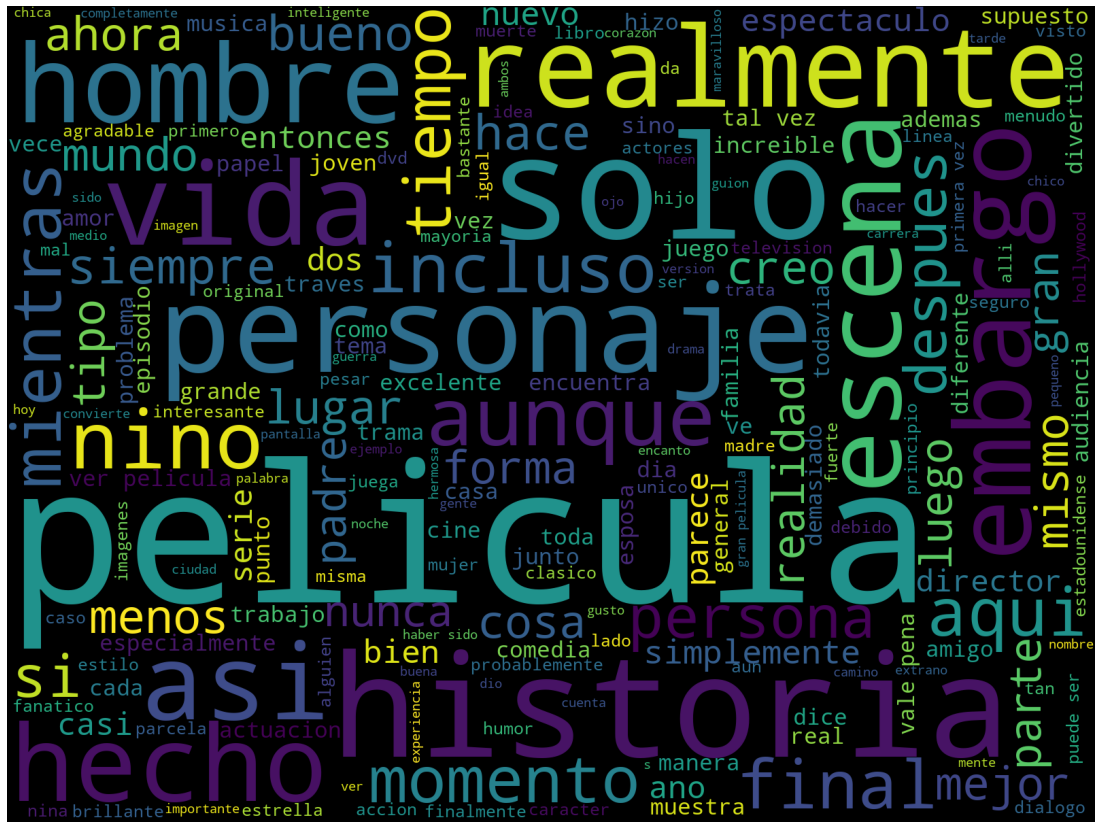

In [37]:
plot_cloud(data_pos)

Vemos que aparecen palabras como 'excelente', 'mejor', 'buen', 'disfrutar', 'divertido', etc.

**Muestra la nube de palabras de las reseñas negativas. ¿Qué palabras te llaman la atención?**

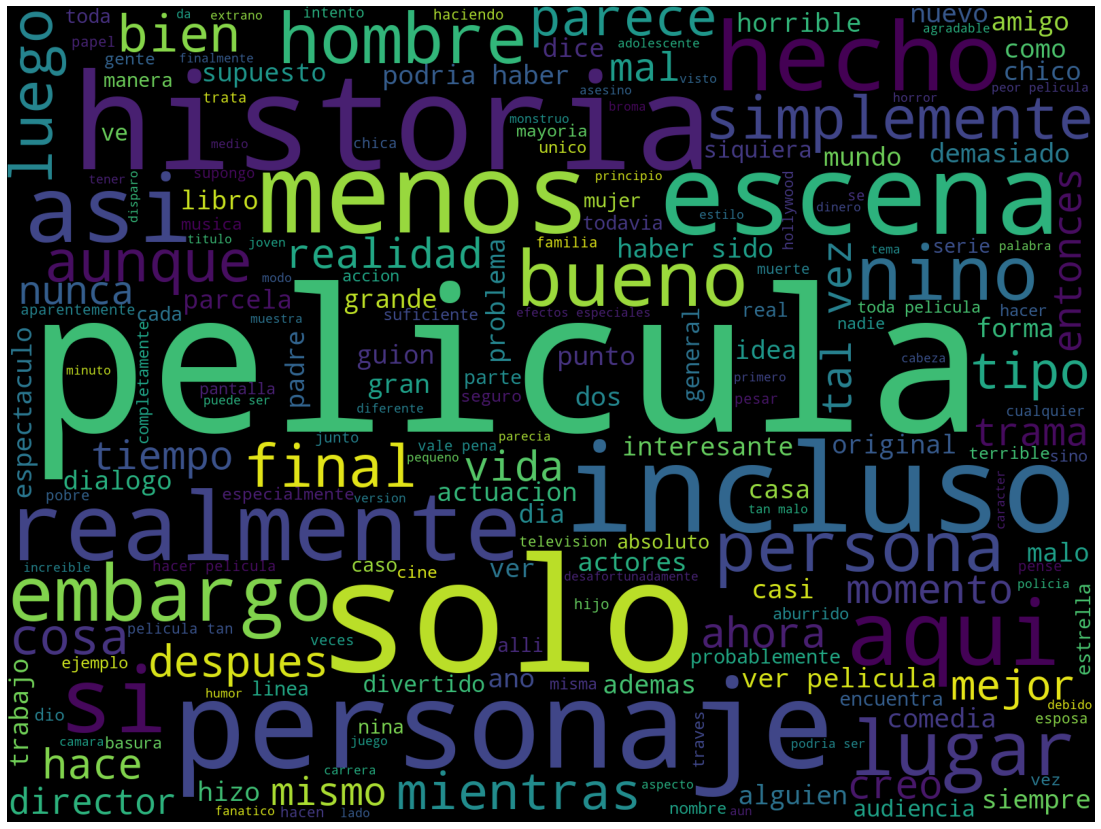

In [38]:
plot_cloud(data_neg)


Vemos que aparecen palabras como 'malo', 'terrible', 'horrible', 'peor', etc.

## Longitud de los textos

**Siempre es conveniente comprobar la longitud de los textos por si esto nos pudiera dar alguna pista. Crea un histograma que compare la distribución de la longitud de los textos de las reseñas para ambas etiquetas de salida. ¿Qué observas?**

In [39]:
pos=[]
for i in data_pos.index:
  pos.append(len(data_pos[i]))

Text(0.5, 1.0, 'Positive Reviews Distribution')

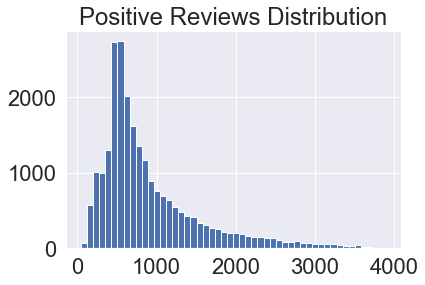

In [40]:
plt.hist(pos,50)
plt.title('Positive Reviews Distribution')

In [41]:
neg=[]
for i in data_neg.index:
  neg.append(len(data_neg[i]))

Text(0.5, 1.0, 'Negative Reviews Distribution')

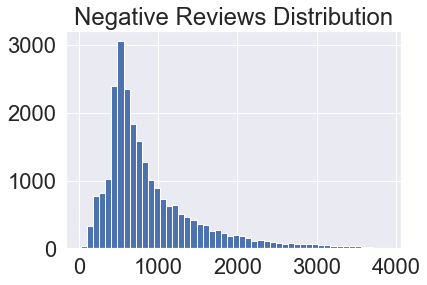

In [42]:
plt.hist(neg,50)
plt.title('Negative Reviews Distribution')

> Vemos que en las reviews negativas hay más palabras

## Entrenamiento del modelo

Vamos a usar la clase [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) de Scikit-Learn para crear un flujo que nos permita:
1. Vectorizar los textos usando [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
2. Entrenar un clasificador de tipo [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomialnb#sklearn.naive_bayes.MultinomialNB).

**Separa la variable de entrada, en este caso la columna `review_es_clean` que contiene los textos preprocesados, de la variable de salida y asígnalas a dos variables llamadas `X` e `y` respectivamente.**

In [43]:
x=data['review_es_clean']
y=data['sentiment']

**Divide el dataset en los conjuntos de entrenamiento y prueba en una proporción de 80/20.**

In [44]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

**Usando la clase `Pipeline` instancia un flujo que primero vectorice los textos de las reseñas usando `TfidfVectorizer` y, a continuación, entrene un clasificador de tipo Naive Bayes multinomial usando la matriz de características TF-IDF generada al vectorizar.**

In [45]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                      ('clf', MultinomialNB()) ])

**Ahora vamos realizar una búsqueda de hiperparámetros usando `GridSearchCV`. A continuación, te dejamos como sugerencia algunos valores para los hiperparámetros que puedes ajustar, aunque puedes usar los que quieras. Comenta y descomenta lo que consideres, pero ten en cuenta que el tiempo de búsqueda crecerá de forma exponencial al número de valores que quieras probar, ¡elige sabiamente!**

In [46]:
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 3, 5),
    'tfidf__max_features': (None, 5000, 10000, 50000),
    #'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2', None),
    'clf__alpha': (1, 0.1, 0.001)
}

In [47]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__alpha', 'clf__class_prior', 'clf__fit_prior'])

**Instancia la clase `GridSearchCV` a la que le pasaremos nuestro pipeline y el diccionario con los hiperparámetros. Te aconsejamos un `cv=3` para reducir el tiempo de entrenamiento**

In [48]:
 grid_search = GridSearchCV(pipe, parameters, cv=3,
                                     n_jobs=-1)

**Usa la función `fit()` para realizar la búsqueda de hiperparámetros en la instancia de `GridSearchCV` que acabas de crear. ¡Ojo! Es paso puede tardar bastante en función de los valores de hiperparámetros que hayas elegido.**

In [49]:
 grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1, 0.001),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__max_features': (None, 5000, 10000, 50000),
                         'tfidf__min_df': (1, 3, 5)})

**Una vez terminada la búsqueda imprime la mejor puntuación obtenida, así como el mejor conjunto de hiperparámetros encontrado.**

In [50]:
 grid_search.best_params_

{'clf__alpha': 1,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': None,
 'tfidf__min_df': 1}

In [51]:
 grid_search.best_score_

0.8580064342050644

**Ahora que tenemos los hiperparámetros que mejor funcionan, instancia de nuevo el pipeline con ellos y entrena el clasificador usando los hiperparámetros seleccionados.**

In [52]:
# Instancia el flujo

pipe = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5,min_df=1,max_features=None)), 
                      ('clf', MultinomialNB(alpha=1)) ])

In [53]:
# Realiza el entrenamiento
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.5)),
                ('clf', MultinomialNB(alpha=1))])

## Evaluación del modelo

**Realiza las predicciones para el conjunto de prueba.**

In [58]:
y_pred = pipe.predict(X_test)

**Imprime el accuracy score para el conjunto de prueba del modelo que acabas de entrenar.**

In [57]:
print(f'Acurracy score para el conjunto de entrenamiento es {pipe.score(X_train, y_train)}')

Acurracy score para el conjunto de entrenamiento es 0.9163293897882939


**Muestra la matriz de confunsión para el clasificador.**

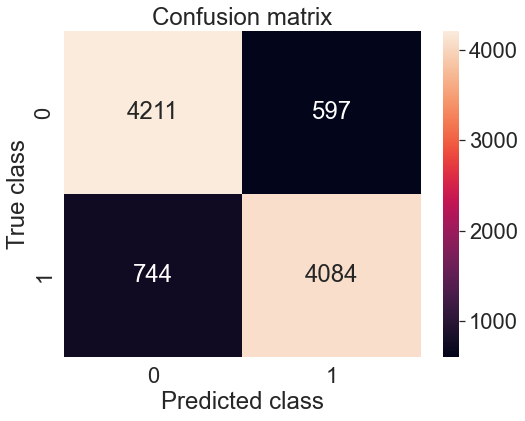

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=[8, 6])
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class');

**Imprime el informe de clasificación.**

In [63]:
report = classification_report(y_test, y_pred)
print('Informe de clasificación\n', report)

Informe de clasificación
               precision    recall  f1-score   support

    negativo       0.85      0.88      0.86      4808
    positivo       0.87      0.85      0.86      4828

    accuracy                           0.86      9636
   macro avg       0.86      0.86      0.86      9636
weighted avg       0.86      0.86      0.86      9636



**Por último, crea una visualización con la curva ROC y la métrica del área bajo la curva.**

In [68]:
# Calcula las métricas
probs = pipe.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label='positivo')
roc_auc = auc(fpr, tpr)

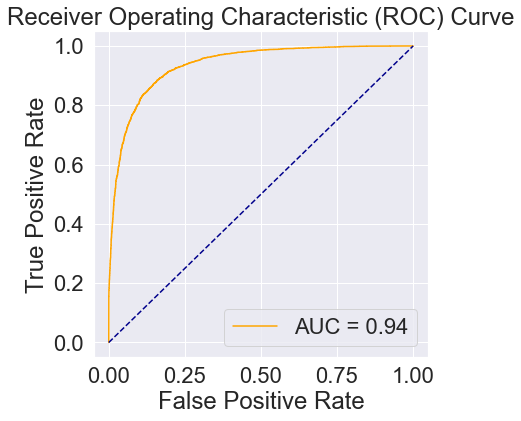

In [75]:
# Muestra el gráfico
def plot_roc_curve(fpr, tpr):  
    plt.figure(figsize=[6, 6])
    plt.plot(fpr, tpr, color='orange',
             label='AUC = %0.2f' % (roc_auc))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr, tpr)

El área bajo la curva (AUC) es 0.94, por lo que hay 94% de posibilidades de que el modelo pueda distinguir entre una reseña positiva y negativa.

## Realizar predicciones

Ahora lo que vamos a hacer es pasar al modelo entrenado nuestras propias reseñas y ver cómo se comporta el clasificador. Recuerda que estás reseñas tienen que llevar el mismo preprocesamiento que hemos usado para crear los conjuntos de entrenamiento y prueba (todo en minúsculas, sin acentos ni símbolos de puntuación, etc.).

**Inventa una reseña positiva y otra negativa y pásaselas al modelo para ver qué etiqueta les pone.**

In [193]:
# Reseña positiva
text_pos=' Es muy buena  película, muy fiel a las leyes físicas y la banda sonora es muy buena'


In [194]:
# Reseña negativa
text_neg='Sharknado es la peor película de todos los tiempos'

In [195]:
def eda_text(text):
    text=text.lower()
    text=text.replace(',',' ')
    text=text.replace(digits,' ')
    re.sub(' +', ' ', text)
    text=text.strip()
    text=remove_stopwords(text)
    text=strip_accents(text)
    return text

In [198]:
text_pos=eda_text(text_pos)
print(text_pos)

buena pelicula fiel leyes fisicas banda sonora buena


In [199]:
text_neg=eda_text(text_neg)
print(text_neg)

sharknado peor pelicula tiempos


In [205]:
y_text = pipe.predict([text_pos,text_neg])
print(y_text)

['positivo' 'negativo']


**(Opcional) Crea una función a la que le pasemos una lista con las reseñas sin preprocesar y nos las devuelva preprocesadas para pasárselas al modelo.**

In [217]:
# Define la función de preprocesamiento de los textos
def eda_text2(text):
    for i in range(0,len(text)):
        text[i]=text[i].lower()
        text[i]=text[i].replace(',',' ')
        text[i]=text[i].replace(digits,' ')
        re.sub(' +', ' ', text[i])
        text[i]=text[i].strip()
        text[i]=remove_stopwords(text[i])
        text[i]=strip_accents(text[i])
    return text

In [218]:
text_pos2=' Es muy buena  película, muy fiel a las leyes físicas y la banda sonora es muy buena'

In [219]:
text_neg2='Sharknado es la peor película de todos los tiempos'

In [220]:
# Crea una lista con las reseñas en bruto
reviews_list=[text_pos2, text_neg2]

In [221]:
# Preprocesa las reseñas y guárdalas en una variable
eda_text2(reviews_list)

['buena pelicula fiel leyes fisicas banda sonora buena',
 'sharknado peor pelicula tiempos']

In [223]:
# Haz la predicción para las reseñas preprocesadas
y_text2 = pipe.predict(reviews_list)
print(y_text2)

['positivo' 'negativo']
